# Analysis of LSE's Strategy

# Key words count

### Loading Data

In [24]:
from pypdf import PdfReader
import re
import pandas as pd
import spacy
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tqdm.autonotebook import tqdm

In [25]:
def get_text_from_strategy_pdf(file_name: str):
    reader = PdfReader(file_name)
    text = "".join(reader.pages[i].extract_text() or "" for i in range(1, len(reader.pages)))

    text = re.sub(r'(?<=\w)-\s*\n\s*(?=\w)', '', text)

    text = re.sub(r'\n{2,}', '\n', text)   
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}',  ' ', text)
    text = text.lower()
    
    return text.strip()


In [26]:
text = get_text_from_strategy_pdf('СЕМИНАР 4/LONDON SCHOOL OF ECONOMICS STRATEGY.pdf')

text

'as approved by council, 5 feb 2019 2 our purpose & vision lse opened its doors in 1895 with three rooms and 200 students, the majority of whom studied part-time in evening classes. in 1919, william beveridge led a period of rapid intellectual and physical deve lopment for the school, and a century later lse looks very different. as we now share this strategy and vision for the future, we are building from a global reputation for excellence in teaching, research, and public engagement in the social sciences. we have a transformed campus, and 11,000 core residential students with 40,000 more through our extended programming. nonetheless, wide consultation with staff, students, alumni and friends of lse has confirmed an unequivocal ongoing commitment to the original vision for lse as: a community of people and ideas, founded to know the causes of things, for the betterment of society . as the world around us changes, we need to work harder than ever to help shape the world’s political, e

### Naive approach

<Axes: title={'center': 'Key Words Count (Naive approch)'}, xlabel='Key Words', ylabel='Count'>

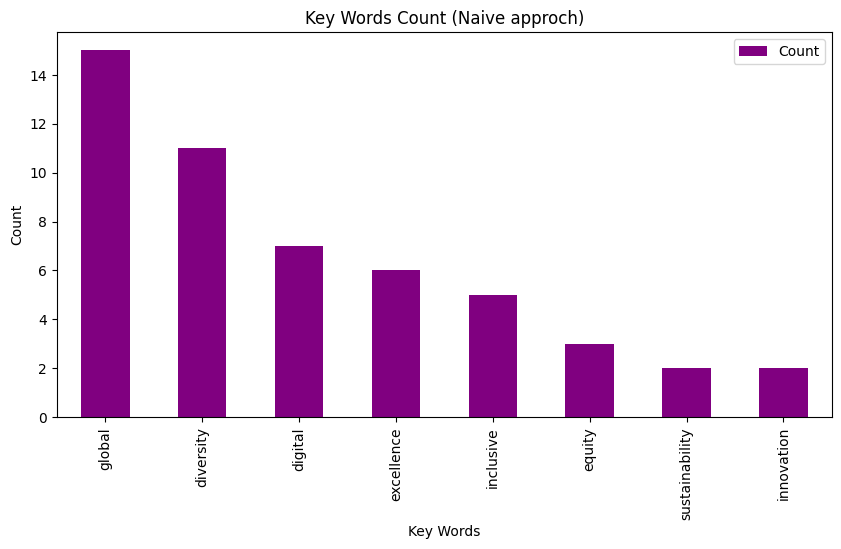

In [27]:
key_words = ['Equity', 'Diversity', 'Excellence', 'Inclusive', 'Sustainability', 'Innovation', 'Global', 'Digital']

key_words = [word.lower() for word in key_words]

dict_key_words = {}

for key_word in key_words:
    dict_key_words[key_word] = text.count(key_word)

df_naive = pd.DataFrame.from_dict(dict_key_words, orient='index', columns=['Count'])
df_naive.sort_values(by='Count', ascending=False, inplace=True)
df_naive.plot(kind='bar', figsize=(10, 5), legend=True, title='Key Words Count (Naive approch)', xlabel='Key Words', ylabel='Count', color='purple')

In [28]:
df_naive

,Count
global,15
diversity,11
digital,7
excellence,6
inclusive,5
equity,3
sustainability,2
innovation,2


### Lemmatization approach

In [29]:
keyword_groups = {
    "equity":        ["equity", "equal", "equality", "parity", "fairness"],
    "diversity":     ["diversity", "diverse", "heterogeneous"],
    "excellence":    ["excellence", "excellent", "top", "outstanding", "world-class"],
    "inclusive":     ["inclusion", "inclusive", "belonging"],
    "sustainability":["sustainability", "sustainable", "sustain", "net-zero", "carbon neutral"],
    "innovation":    ["innovation", "innovative", "creativity", "creative", "entrepreneurship"],
    "global":        ["global", "international", "worldwide", "transnational"],
    "digital":       ["digital", "digitisation", "digitalisation", "online", "tech-enabled"]
}

In [30]:
def count_with_lemmas(lemma_counts, groups):
    return {
        label: sum(lemma_counts[w.lower()] for w in words)
        for label, words in groups.items()
    }

In [31]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
lemmas = [tok.lemma_.lower() for tok in doc if tok.is_alpha]
lemma_counts = Counter(lemmas)

In [32]:
freqs = count_with_lemmas(lemma_counts, keyword_groups)

<Axes: title={'center': 'Key Words Count (Lemmas)'}, xlabel='Key Words', ylabel='Count'>

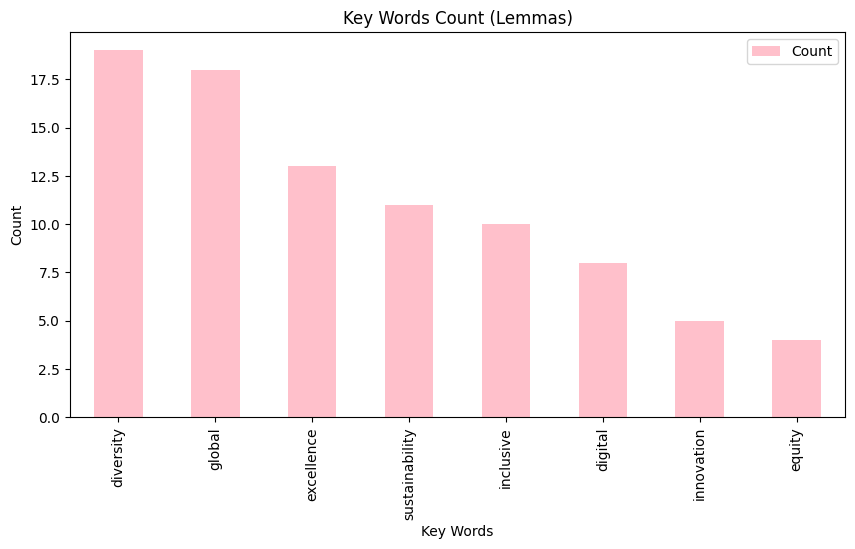

In [33]:
df_lemmas = pd.DataFrame.from_dict(freqs, orient='index', columns=['Count'])
df_lemmas.sort_values(by='Count', ascending=False, inplace=True)
df_lemmas.plot(kind='bar', figsize=(10, 5), legend=True, title='Key Words Count (Lemmas)', xlabel='Key Words', ylabel='Count', color='pink')

In [34]:
df_lemmas

,Count
diversity,19
global,18
excellence,13
sustainability,11
inclusive,10
digital,8
innovation,5
equity,4


### Embeddings aproach 

In [35]:
def clean_text(text:str) -> list[str]:
    text = re.sub(r'(?<=\w)-\s*\n\s*(?=\w)', '', text)
    text = re.sub(r'\s*\n\s*', ' ', text)
    text = re.sub(r'\s{2,}',  ' ', text)
    sentences = nltk.sent_tokenize(text)
    return sentences

In [36]:
anchors = {k: " ".join(v) for k, v in keyword_groups.items()}
anchors

{'equity': 'equity equal equality parity fairness',
 'diversity': 'diversity diverse heterogeneous',
 'excellence': 'excellence excellent top outstanding world-class',
 'inclusive': 'inclusion inclusive belonging',
 'sustainability': 'sustainability sustainable sustain net-zero carbon neutral',
 'innovation': 'innovation innovative creativity creative entrepreneurship',
 'global': 'global international worldwide transnational',
 'digital': 'digital digitisation digitalisation online tech-enabled'}

In [37]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

sentences = clean_text(text)
sent_emb = model.encode(sentences, batch_size=64, convert_to_tensor=True)

In [38]:
TOP_K = 3

results = {}
for label, anchor_phrase in anchors.items():
    anchor_emb  = model.encode(anchor_phrase, convert_to_tensor=True)
    sim_scores  = util.cos_sim(anchor_emb, sent_emb)[0]
    TH = 0.25                                          

    hits     = int((sim_scores > TH).sum())
    avg_sim  = float(sim_scores.mean())
    max_sim  = float(sim_scores.max())

    top_idx  = torch.topk(sim_scores, k=TOP_K).indices
    top_snts = [sentences[i] for i in top_idx]

    results[label] = {
        "hits": hits,
        "avg":  avg_sim,
        "max":  max_sim,
        "examples": top_snts
    }

results

{'equity': {'hits': 3,
  'avg': 0.08935899287462234,
  'max': 0.3426356315612793,
  'examples': ['in line with our public sector equality duty, we will continually assess the impact of our processes and procedures to identify and mitigate differential impacts and potential inequalities.',
   '3.3 champion equity, diversity and inclusion lse is committed to championing equity, diversity and inclusion, both internally by building a school community where everybody’s contribution is valued, and in addressing broader societal challenges.',
   'all that we do will reflect the importance we place on equity, diversity and inclusion, ensuring that lse is a stimulating and supportive environm ent for work and study, and recognised as a place for serious debate where diverse viewpoints are respectfully but rigorously contested.']},
 'diversity': {'hits': 12,
  'avg': 0.15583772957324982,
  'max': 0.45912235975265503,
  'examples': ['it is core to our identity that we nurture a vibrant, open and 

<Axes: title={'center': '"Key Words Count" (Embeddings)'}, xlabel='Key Words', ylabel='Count'>

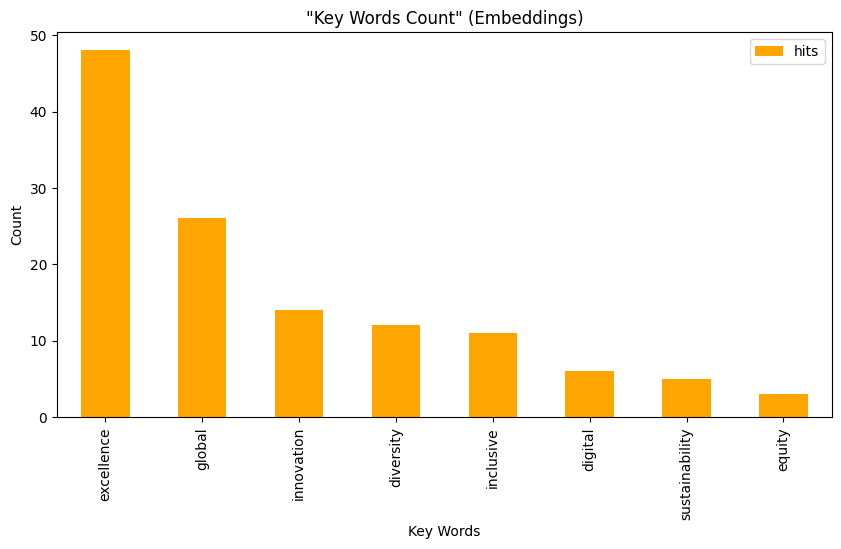

In [39]:
df_embeddings = pd.DataFrame.from_dict(results, orient='index')
df_embeddings.sort_values(by='hits', ascending=False, inplace=True)
df_embeddings['hits'].plot(kind='bar', figsize=(10, 5), legend=True, title='"Key Words Count" (Embeddings)', xlabel='Key Words', ylabel='Count', color='orange')

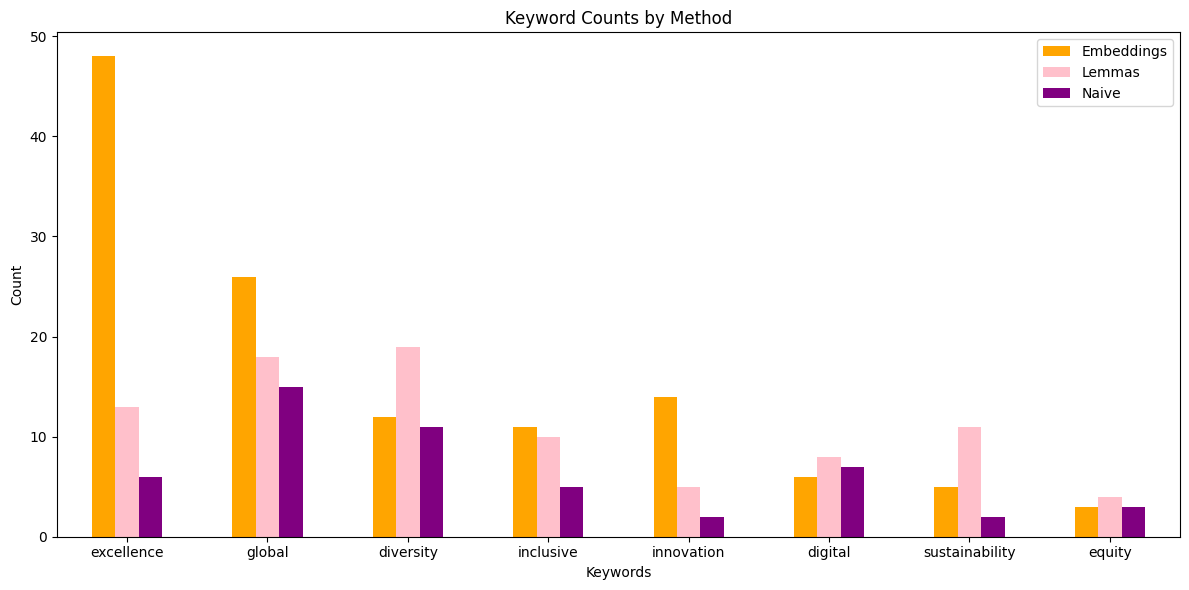

In [40]:
df_plot = pd.concat([df_embeddings['hits'].rename('Embeddings'), df_lemmas['Count'].rename('Lemmas'),df_naive['Count'].rename('Naive')],axis=1).fillna(0)

df_plot = df_plot.loc[df_plot.sum(axis=1).sort_values(ascending=False).index]

ax = df_plot.plot(kind='bar',figsize=(12, 6),rot=0,color=['orange', 'pink', 'purple'])

ax.set_title('Keyword Counts by Method')
ax.set_xlabel('Keywords')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### KeyWordsRank

In [41]:
doc_paths = sorted(Path("СЕМИНАР 4").glob("*.pdf"))

In [42]:
texts = [get_text_from_strategy_pdf(p) for p in tqdm(doc_paths)]
texts

  0%|          | 0/6 [00:00<?, ?it/s]

['introduction 4 1. the demographic and economic scenario 14 2. the job market: trends, challenges and opportunities 24 part 2 3. the competitive landscape: trends, challenges and opportunities 32 3.1 the main trends affecting the demand for higher education 34 3.2 main trends affecting the supply of higher education 39 3.3 the relevance of the european dimension 50 part 1 4. strategic goals driving vision 2030 56 1. a leading independent international university in the social sciences 58 2. a university committed to the advancement of knowledge through rigorous and relevant research 59 3. a university offering a life transforming learning experience of the highest academic quality 60 4. a university promoting impact and engagement of all its stakeholders 62 5. an open university supporting social mobility, inclusivity, diversity and sustainability 63 6. a university promoting innovation and entrepreneurship 64 5. strategic plan 2021-2025 66 1. main quantitative targets for 2025 68 2. 

In [ ]:
uni_names = {p.stem.lower().split()[0]
             for p in doc_paths}

extra_stop = {
    "university", "college", "school",
    "strategy", "strategic", "plan", "page"
}.union(uni_names)

stop_words = set(nltk.corpus.stopwords.words("english")).union(extra_stop)

def spacy_tokenizer(text: str) -> list[str]:
    doc = nlp(text.lower())
    good_pos = {"NOUN", "ADJ"}
    return [По
        tok.lemma_
        for tok in doc
        if tok.pos_ in good_pos
        and tok.is_alpha
        and tok.lemma_ not in stop_words
        and len(tok) > 2
    ]


In [44]:
vectorizer = TfidfVectorizer(
    tokenizer=spacy_tokenizer,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.5,
)

X = vectorizer.fit_transform(texts)
terms = np.array(vectorizer.get_feature_names_out())

C:\Users\kiril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [47]:
TOP_N = 15
cols = []

for i, doc_name in enumerate([p.stem for p in doc_paths]):
    row_vec  = X[i].toarray().ravel()
    top_idx  = row_vec.argsort()[::-1][:TOP_N]

    df_doc = pd.DataFrame({
        "Term" :  terms[top_idx],
        "Score":  row_vec[top_idx].round(3)
    })
    df_doc.columns = pd.MultiIndex.from_product([[doc_name], df_doc.columns])
    cols.append(df_doc.reset_index(drop=True))

kw_table = pd.concat(cols, axis=1)
kw_table.index = [f"Rank {i+1}" for i in range(TOP_N)]


In [48]:
kw_table

BOCCONI UNIVERSITY STRATEGY        CAIP TOWN UNIVERSITY STRATEGY  \
                               Term  Score                          Term   
Rank 1                      program  0.380                          fair   
Rank 2                       decade  0.302                      function   
Rank 3                       source  0.268                       ability   
Rank 4                       figure  0.257                       cutting   
Rank 5                     analysis  0.212             teaching learning   
Rank 6                     european  0.212                    curriculum   
Rank 7                     industry  0.212                       natural   
Rank 8                     pandemic  0.190                    creativity   
Rank 9                     relevant  0.179                      document   
Rank 10                        main  0.179                          vice   
Rank 11                   corporate  0.168                   fundamental   
Rank 12                         one  0.168                    inequality   
Rank 13                      factor  0.156                          edge   
Rank 14                     ability  0.134                       element   
Rank 15                       table  0.134                      pandemic   

               COPENHAGEN UNIVERSITY STRATEGY         \
         Score                           Term  Score   
Rank 1   0.490                       ambition  0.448   
Rank 2   0.354                      curiosity  0.320   
Rank 3   0.218                       lifelong  0.320   
Rank 4   0.218                       alliance  0.192   
Rank 5   0.191                     high level  0.192   
Rank 6   0.191                       talented  0.192   
Rank 7   0.163                       constant  0.192   
Rank 8   0.163                      programme  0.192   
Rank 9   0.163                     transition  0.192   
Rank 10  0.163                     democratic  0.128   
Rank 11  0.136                          green  0.128   
Rank 12  0.136       professional development  0.128   
Rank 13  0.136                       european  0.128   
Rank 14  0.136                   breakthrough  0.128   
Rank 15  0.109                 community good  0.128   

        LONDON SCHOOL OF ECONOMICS STRATEGY         \
                                       Term  Score   
Rank 1                            programme  0.382   
Rank 2                               sector  0.273   
Rank 3                               debate  0.273   
Rank 4                  diversity inclusion  0.273   
Rank 5                   student experience  0.218   
Rank 6                           curriculum  0.164   
Rank 7                             standard  0.164   
Rank 8                     researcher world  0.164   
Rank 9                             rigorous  0.164   
Rank 10                          inequality  0.164   
Rank 11                             natural  0.109   
Rank 12                            systemic  0.109   
Rank 13                             serious  0.109   
Rank 14                          investment  0.109   
Rank 15                           awareness  0.109   

        STANFORD UNIVERSITY STRATEGY        University of TOKYO         
                                Term  Score                Term  Score  
Rank 1                         ideal  0.838            humanity  0.340  
Rank 2                implementation  0.273             project  0.340  
Rank 3                          vice  0.234            creation  0.260  
Rank 4                        office  0.195          investment  0.249  
Rank 5                  postdoctoral  0.156             program  0.238  
Rank 6                 faculty staff  0.117               asset  0.215  
Rank 7              member community  0.097                city  0.215  
Rank 8                       program  0.068                fund  0.215  
Rank 9                  organization  0.068              figure  0.204  
Rank 10                working group  0.